In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df_train = pd.read_csv('sample_data/sensor_data_train.csv')
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train['minute'] = df_train['timestamp'].dt.hour * 60 + df_train['timestamp'].dt.minute
df_train = df_train.drop('timestamp', axis=1)
df_train = df_train.drop('sensor_id', axis=1)
df_train.head()

,value,minute
0,65.18,0
1,64.80,1
2,64.92,2
3,64.93,3
4,64.61,4


In [18]:
df_test = pd.read_csv('sample_data/sensor_data_test.csv')
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test['minute'] = df_test['timestamp'].dt.hour * 60 + df_test['timestamp'].dt.minute
df_test = df_test.drop('timestamp', axis=1)
df_test = df_test.drop('sensor_id', axis=1)
df_test.head()

,value,minute
0,65.32,0
1,64.78,1
2,65.06,2
3,64.90,3
4,65.23,4


In [26]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from ngboost import NGBRegressor
from ngboost.distns import Normal

In [22]:
X = df_train.minute.to_numpy().reshape(-1, 1)
y = df_train.value.to_numpy()
# y = y.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [27]:
ngb = NGBRegressor(Dist=Normal).fit(X_train, y_train)
y_preds = ngb.predict(X_val)
y_dists = ngb.pred_dist(X_val)

# Validation metrics
mse = mean_squared_error(y_preds, y_val)
mae = mean_absolute_error(y_preds, y_val)
rmse = root_mean_squared_error(y_preds, y_val)
print('MSE', mse)
print('MAE', mae)
print('RMSE', rmse)

[iter 0] loss=2.6842 val_loss=0.0000 scale=1.0000 norm=3.2361
[iter 100] loss=1.8492 val_loss=0.0000 scale=2.0000 norm=2.0348
[iter 200] loss=0.8932 val_loss=0.0000 scale=2.0000 norm=1.0717
[iter 300] loss=0.1275 val_loss=0.0000 scale=2.0000 norm=0.9133
[iter 400] loss=-0.1728 val_loss=0.0000 scale=2.0000 norm=0.9311
MSE 0.040677271237901255
MAE 0.16070500701215845
RMSE 0.20168607100615862


In [28]:
from scipy import stats

grid_X = np.linspace(start=min(X), stop=max(X), num=1000)
grid_y_dist = ngb.pred_dist(X=grid_X.reshape(-1, 1))
quantile_lower = [stats.norm.ppf(q=0.005, **dist.params) for dist in grid_y_dist]
quantile_upper = [stats.norm.ppf(q=0.995, **dist.params) for dist in grid_y_dist]

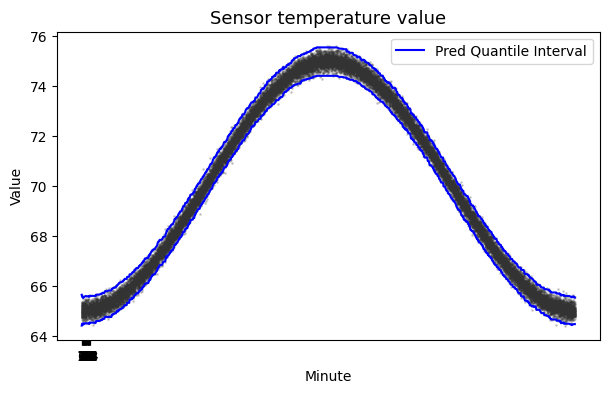

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
ax.scatter(X, y, alpha = 0.2, c = "#333", s=1)
ax.plot(grid_X, quantile_lower, c = "blue", label='Pred Quantile Interval')
ax.plot(grid_X, quantile_upper, c = "blue")
ax.set_xticks(range(0,25))
ax.set_title('Sensor temperature value', fontdict={'fontsize':13})
ax.set_xlabel('Minute')
ax.set_ylabel('Value')
plt.legend();

In [30]:
y_dist = ngb.pred_dist(X=X)
y_quantile_lower = [stats.norm.ppf(q=0.005, **dist.params) for dist in y_dist]
y_quantile_upper = [stats.norm.ppf(q=0.995, **dist.params) for dist in y_dist]

inside = np.where((y >= y_quantile_lower) & (y <= y_quantile_upper), True, False)
print(f"Values inside the interval: {100 * inside.mean()}")

Values inside the interval: 99.15013227513228


In [31]:
X_test = df_test.minute.to_numpy().reshape(-1, 1)
y_test = df_test.value.to_numpy()
y_dist = ngb.pred_dist(X_test)
alpha = 0.01
quantile_lower = [stats.norm.ppf(q=alpha/2, **dist.params) for dist in y_dist]
quantile_upper = [stats.norm.ppf(q=1-alpha/2, **dist.params) for dist in y_dist]
anomaly = np.where((y_test >= quantile_lower) & (y_test <= quantile_upper), False, True)
df_test["anomaly"] = anomaly

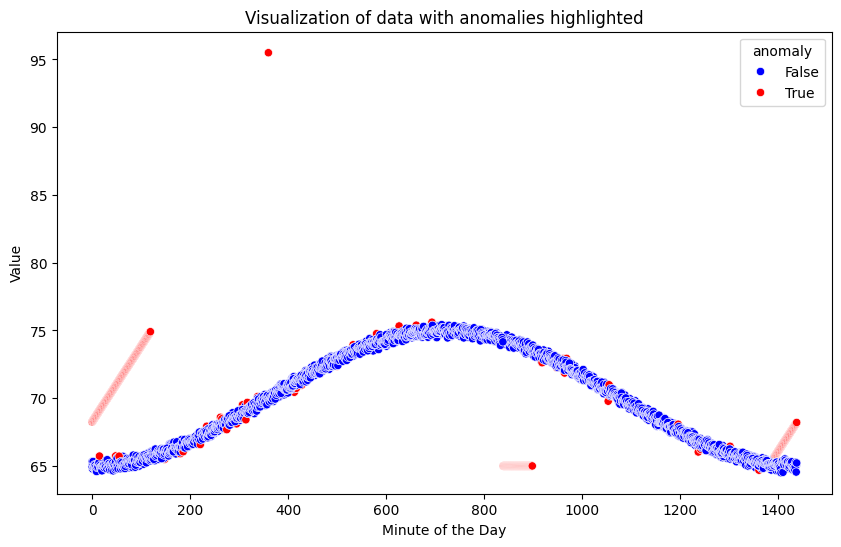

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_test['minute'], y=df_test['value'], hue=df_test['anomaly'], palette={True: 'red', False: 'blue'}, legend='full')
plt.title('Visualization of data with anomalies highlighted')
plt.xlabel('Minute of the Day')
plt.ylabel('Value')
plt.show()